In [268]:
try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

In [269]:
from params import params,today,cols
from functions import *

display(params)

{'country': 'spain',
 'region': 'andalucia',
 'sub_region': 'cordoba',
 'formato': '%Y-%m-%d',
 'formato_query': '%Y-%m-%d',
 'start_date': datetime.datetime(2020, 12, 24, 0, 0),
 'end_date': datetime.datetime(2021, 1, 15, 0, 0)}

## COVID 19 - API
- Page: https://covid19tracking.narrativa.com/es/spain/api.html
- Docs: https://documenter.getpostman.com/view/10831675/SzYZ1eNY#intro

### DataFrame hierarchical call: 
- df = pd.DataFrame(json["dates"][params["start_date"].strftime(formato)]["countries"]["Spain"])

In [270]:
# PRE-PROCESSING params:
params["start_date"] = datetime.datetime(2020,12,24)
params["end_date"] = datetime.datetime(2021,1,15)

# API call:
json = api_covid19tracking(**params)

# DataFrame creation
df = daterange2df(json=json, **params)

pre-url: https://api.covid19tracking.narrativa.com/api/country/{0}/region/{1}/sub_region/{2}
url: https://api.covid19tracking.narrativa.com/api/country/spain/region/andalucia/sub_region/cordoba 
query_url:https://api.covid19tracking.narrativa.com/api/country/spain/region/andalucia/sub_region/cordoba?date_from=2020-12-24&date_to=2021-01-15
status_code:200
dl:[datetime.datetime(2021, 1, 15, 0, 0), datetime.datetime(2021, 1, 14, 0, 0), datetime.datetime(2021, 1, 13, 0, 0), datetime.datetime(2021, 1, 12, 0, 0), datetime.datetime(2021, 1, 11, 0, 0), datetime.datetime(2021, 1, 10, 0, 0), datetime.datetime(2021, 1, 9, 0, 0), datetime.datetime(2021, 1, 8, 0, 0), datetime.datetime(2021, 1, 7, 0, 0), datetime.datetime(2021, 1, 6, 0, 0), datetime.datetime(2021, 1, 5, 0, 0), datetime.datetime(2021, 1, 4, 0, 0), datetime.datetime(2021, 1, 3, 0, 0), datetime.datetime(2021, 1, 2, 0, 0), datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0), datetime.datetime(2020, 12, 30, 0, 0), 

prefixes:['today' 'yesterday']
 mid_terms:['hospitalised', 'intensive', 'new', 'open', 'total', 'vs']
suffixes:['confirmed' 'deaths' 'symptoms' 'care' 'cases' 'recovered' 'patients']



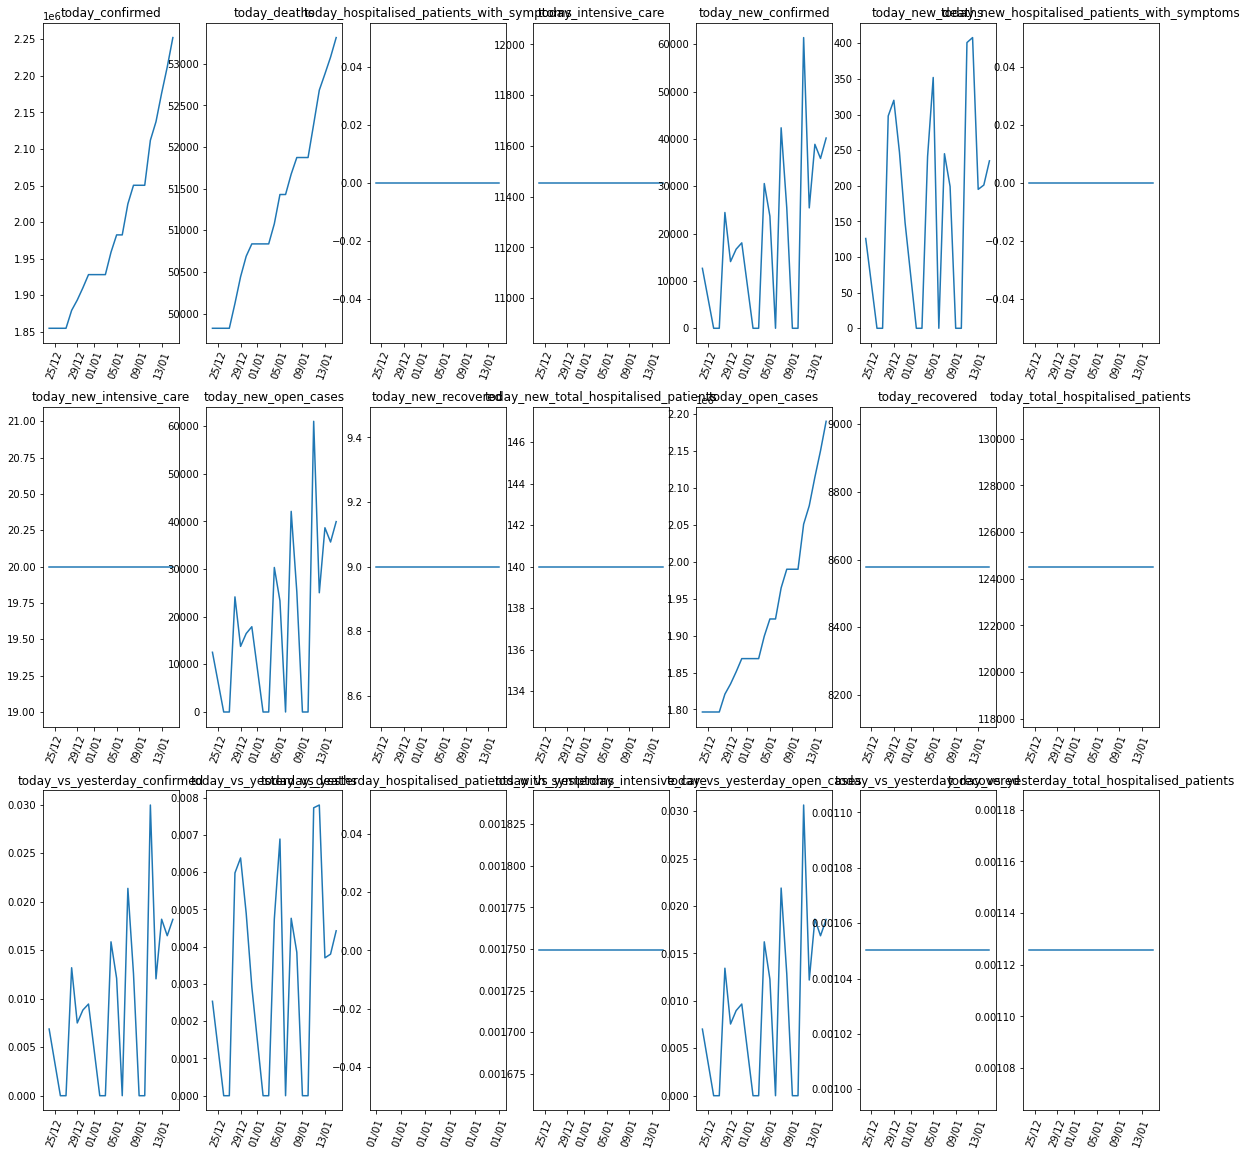

In [271]:
# LEMMAS
prefixes = col_lemma(0)
suffixes = col_lemma(-1)
mid_terms = [i for i in col_lemma(1) if i not in suffixes] # problems with "open","vs" : solo 1 plot
print("prefixes:{}\n mid_terms:{}\nsuffixes:{}\n".format(prefixes,mid_terms,suffixes),)

L = {k:k for k in np.concatenate([prefixes, mid_terms, suffixes])}
fig,axs = make_plots_by_lemma(L["today"], df=df)


In [367]:
from bokeh.plotting import figure, output_file, gridplot
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.io import show, output_notebook, curdoc
from bokeh.models import Circle, Legend, LegendItem
from bokeh.models import CustomJS, Select, DateRangeSlider
from bokeh.palettes import Category20_20
from bokeh.layouts import column,grid, gridplot,row
from random import randint
from datetime import date,datetime

def bokeh_plots_by_lemma(lemma, df=df):
    source = ColumnDataSource(df[colsbylemma(lemma)])
    hover = HoverTool()
    
    # WIDGET pickup
    global dr_sl, sl
    global dr_sl_callback, sl_callback
    dr_sl = DateRangeSlider(value=(date(2021,1,1),date(2021,1,20)),
                            start=date(2020, 4, 20), end=datetime.today()) #start_date, end_date
    dr_sl_callback = CustomJS(args=dict(source=source, data=df.reset_index().to_dict()),
                             code="""
                             console.log(data)
                             data.change.emit()
                             """)
    dr_sl.js_on_change("value",dr_sl_callback)
                                   
    sl = Select(title="Option:", value=lemma, options=list(L.keys()))
    #sl.on_change("value",sl_callback)
    
    # THEME, OUTPUT
    curdoc().theme = "night_sky"  # caliber, dark_minimal, light_minimal, night_sky, contrast
    output_file("/tmp/output_bokeh.html", title="Output Bokeh")

    # figure PARAMETERS
    bokeh_figure_params = dict(tools="pan,tap,box_zoom,reset,save", title="(lemma:)     {}".format(lemma.upper()), 
                               plot_height=650,plot_width=1300,
                               x_axis_type="datetime",
                               sizing_mode="scale_both",
                               outline_line_color="navy", outline_line_width = 7, outline_line_alpha = 0.3)
    p = figure(output_backend="canvas", **bokeh_figure_params)
    p.xaxis.axis_label, p.yaxis.axis_label = ("Date", "Cases")

    

    
    # outer PARAMETERS
    selected_circle = Circle(fill_alpha=1,fill_color="red")
    nonselected_circle = Circle(fill_alpha=0.1, fill_color="blue",line_color="firebrick")

    bokeh_plotparams= dict(x="date", y=None, source=source, muted_alpha=0.1)
    it_legend = []
    # RUN!
    for field in colsbylemma(lemma):
        color_i = Category20_20[randint(0,19)]
        bokeh_plotparams.update(dict(y=field, 
                                     muted_color=color_i))
        # line (renderer)
        rl = p.line(name="line",
               line_color=color_i, line_alpha=0.4, line_cap="round",
               **bokeh_plotparams)
        # circle (renderer)
        rcirc = p.circle(name="circle", size=10, 
                         fill_color=color_i, fill_alpha=0.4,
                         **bokeh_plotparams)
        rcirc.selection_glyph = selected_circle
        rcirc.nonselection_glyph = nonselected_circle
        it_legend.append(LegendItem(label=field, renderers=[rl,rcirc]))
    
    # LEGEND
    global leg
    leg_kwargs = {"background_fill_color":"#33ee11",
                  "title":"Legend:", 
                  "title_text_color":"#00aaff",
                  "title_text_font_size":"0.5cm",
                  "title_text_font_style":"bold",                 
                 "label_text_font":"Roboto", 
                  "click_policy" : "mute"}
    leg = Legend(items=it_legend, **leg_kwargs)
    p.add_layout(leg, place="right")
    p.legend.glyph_height, p.legend.glyph_width = (10, 10)
    
    # SHOW
    plotall = True
    if plotall:
        all_things_together = (dr_sl,sl,p)
        show(column(*all_things_together), **dict(browser=None, notebook_handle=False))
    else:
        show(p, **dict(browser=None, notebook_handle=False)) # only the plot
    
    gc.collect()
    return p
    
p = bokeh_plots_by_lemma(lemma=L['yesterday'])

today_confirmed                                              1854951
today_deaths                                                   49824
today_hospitalised_patients_with_symptoms                          0
today_intensive_care                                           11454
today_new_confirmed                                            12662
today_new_deaths                                                 126
today_new_hospitalised_patients_with_symptoms                      0
today_new_intensive_care                                          20
today_new_open_cases                                           12527
today_new_recovered                                                9
today_new_total_hospitalised_patients                            140
today_open_cases                                             1796548
today_recovered                                                 8579
today_total_hospitalised_patients                             124521
today_vs_yesterday_confirmed      